In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from scipy.interpolate import interp1d

(29999, 256)


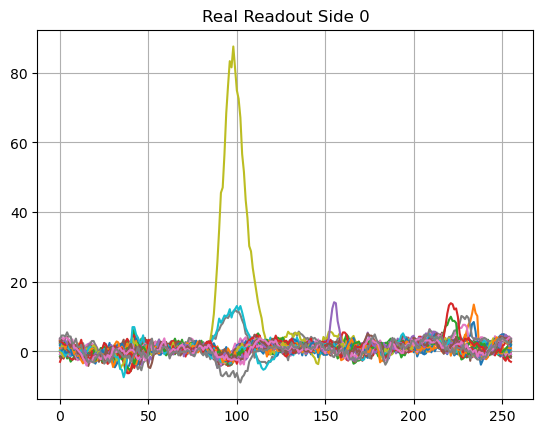

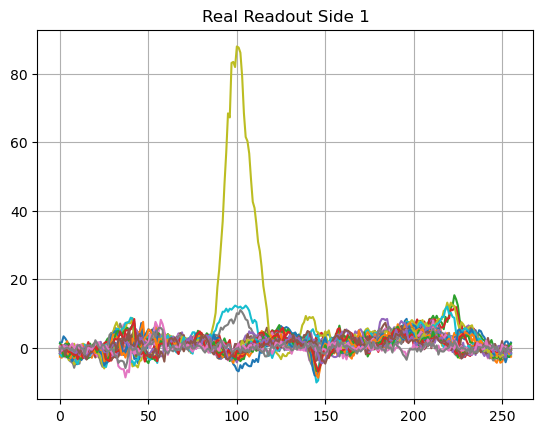

In [46]:
import pandas as pd

# Replace side0.txt and side1.txt with the names of the LAPPD readout files (corresponding to each side of the LAPPD) you wish to analyze
### Must be in same directory as this file

# Read the data for side 0, skipping the first row and the first three columns as per standard LAPPD .txt data file format
data0 = []
with open('side0.txt', 'r') as file:
    for line_number0, line in enumerate(file):
        if line_number0 == 0:  # Skip header
            continue
        if line_number0 == 1:
            continue
        split_line0 = line.strip().split()
        data0.append(split_line0[3:])  # Keep data after the first three columns

# Convert to DataFrame
real_data0 = pd.DataFrame(data0)

# Step 1: Optimize Data Types
real_data0 = real_data0.astype('float32')

# Step 2: Convert to numeric, forcing errors to NaN
real_data0 = real_data0.apply(pd.to_numeric, errors='coerce')

# Step 3: Replace NaN with zero or another appropriate value
real_data0.fillna(0, inplace=True)


# Read the data for side 0, skipping the first row and the first three columns as per standard LAPPD .txt data file format
data1 = []
with open('side1.txt', 'r') as file:
    for line_number1, line in enumerate(file):
        if line_number1 == 0:  # Skip header
            continue
        if line_number1 == 1:
            continue
        split_line1 = line.strip().split()
        data1.append(split_line1[3:])  # Keep data after the first three columns

# Convert to DataFrame
real_data1 = pd.DataFrame(data1)

# Step 1: Optimize Data Types
real_data1 = real_data1.astype('float32')

# Step 2: Convert to numeric, forcing errors to NaN
real_data1 = real_data1.apply(pd.to_numeric, errors='coerce')

# Step 3: Replace NaN with zero or another appropriate value
real_data1.fillna(0, inplace=True)

In [3]:
# Function to load the S-parameters using scikit-rf
### S-parameters file of format .Pp where P is the number of ports must be in same directory as this file

P=56 # Specify number of ports on model LAPPD

def load_s_parameters(file_path, num_ports=P):
    # Read S-parameters from .tab file
    network = rf.Network(file_path)
    return network

# Load the S-parameters using scikit-rf
file_path = f'Sparams.{P}p'
network = load_s_parameters(file_path)

# Time parameters
time_step = 0.1e-9  # 0.1 ns in seconds, same as PSEC
num_time_steps = 256  # 256 PSEC samples

# Define time array
time = np.arange(0, num_time_steps * time_step, time_step)

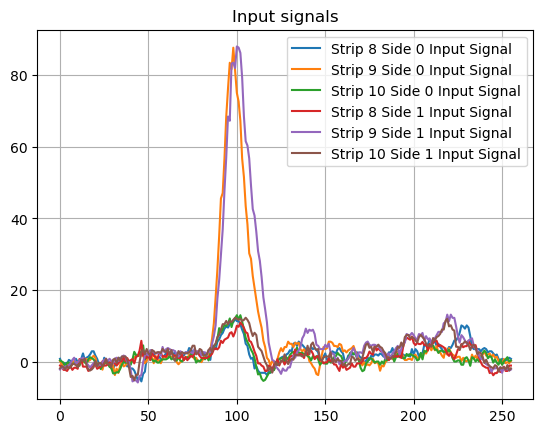

/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


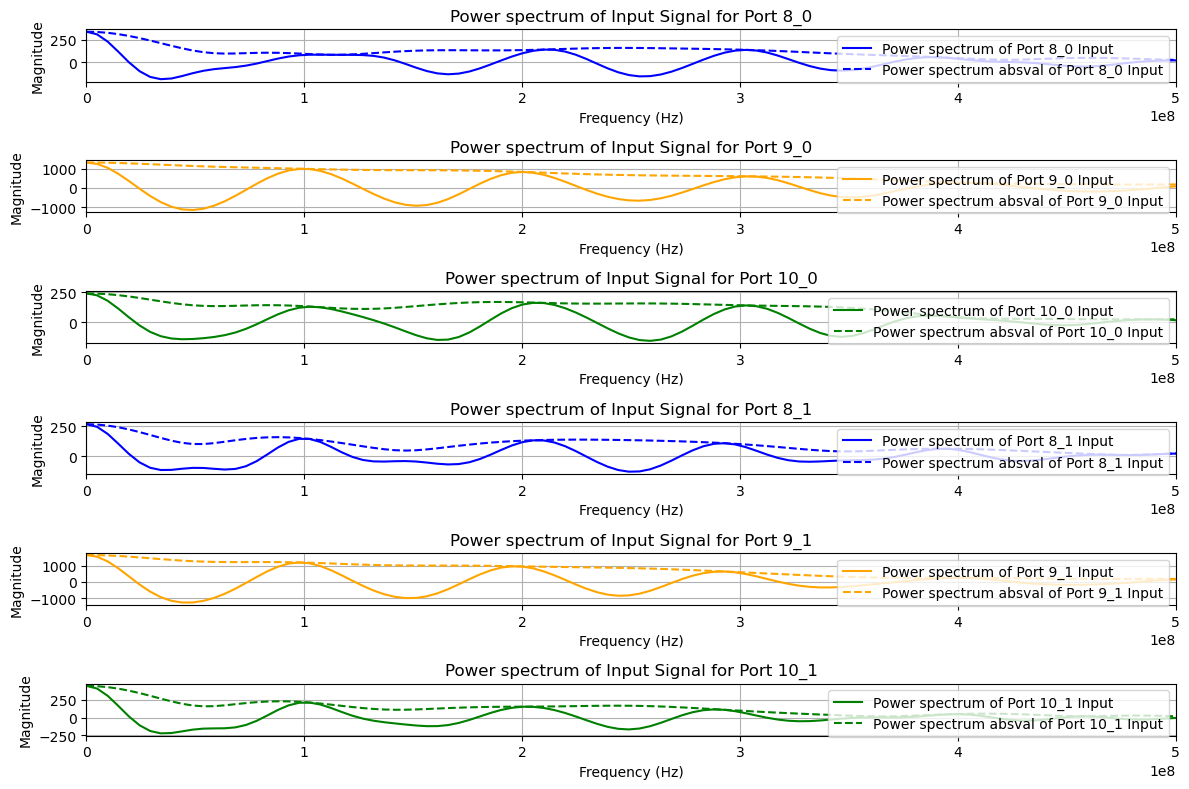

In [48]:
# Assign input pulse data from imported LAPPD data files
### Here, you specify the ports on which the pulses you wish to calculate the crosstalk of were incident. Be aware that this depends om
### on the event you are analyzing. For all intents and purposes here, the events are the first 28 lines in the data files beginning at
### every multiple of 30- the last 2 lines contain trigger signals irrelevant to this analysis

secondary1_row = s1 # Specify microstrip to the left of primary strip
primary_row = p # Specify microstrip on which largest-amplitude pulse was incident
secondary2_row = s2 # Specify microstrip to the right of primary strip

primary_sparam_index_NEXT = 2*p
primary_sparam_index_FEXT = 2*p+1

secondary1_sparam_index_NEXT = 2*s1
secondary1_sparam_index_FEXT = 2*s1+1

secondary2_sparam_index_NEXT = 2*s2
secondary2_sparam_index_FEXT = 2*s2+1


secondary_strip1_side0 = real_data0.iloc[secondary1_row] 
secondary_strip1_side1 = real_data0.iloc[secondary1_row]
primary_strip_side0 = real_data0.iloc[primary_row]
primary_strip_side1 = real_data1.iloc[primary_row]
secondary_strip2_side0 = real_data0.iloc[secondary2_row]
secondary_strip2_side1 = real_data0.iloc[secondary2_row]

plt.plot(secondary_strip1_side0, label='Secondary (1) Side 0 Input Signal')
plt.plot(secondary_strip1_side1, label='Secondary (1) Side 1 Input Signal')
plt.plot(primary_strip_side0, label='Primary Side 0 Input Signal')
plt.plot(primary_strip_side1, label='Primary Side 1 Input Signal')
plt.plot(secondary_strip2_side0, label='Secondary (2) Side 0 Input Signal')
plt.plot(secondary_strip2_side1, label='Secondary (2) Side 1 Input Signal')
plt.legend()
plt.xlabel('Time (.1 ns)')
plt.ylabel('mV')
plt.grid()
plt.title('Input signals')
plt.show()

# Toggle for applying windowing (can improve FFT fidelity)
apply_windowing = True

# Zero-padding the frequency domain data (for better resolution)
num_pad = 2048  # Number of zeros to pad for better resolution (2048 is lowest natural choice)
freq_resampled = np.linspace(network.f[0], network.f[-1], num_pad)  # Create more frequency points according to zero-padding

# Interpolate the S-parameters to higher frequency resolution corresponding to zero-padded domain
s_interpolated = np.zeros((num_pad, P, P), dtype=np.complex64)
for i in range(P):
    for j in range(P):
        interp_func = interp1d(network.f, network.s[:, i, j], kind='linear', fill_value="extrapolate")
        s_interpolated[:, i, j] = interp_func(freq_resampled)

# Apply window function if toggle is on
if apply_windowing:
    window = np.hanning(num_time_steps)  # Hanning window
    secondary_strip1_side0_windowed = secondary_strip1_side0 * window
    secondary_strip1_side1_windowed = secondary_strip1_side1 * window
    primary_strip_side0_windowed = primary_strip_side0 * window
    primary_strip_side1_windowed = primary_strip_side1 * window
    secondary_strip2_side0_windowed = secondary_strip2_side0 * window
    secondary_strip2_side1_windowed = secondary_strip1_side0 * window
else:
    secondary_strip1_side0_windowed = secondary_strip1_side0
    secondary_strip1_side1_windowed = secondary_strip1_side1
    primary_strip_side0_windowed = primary_strip_side0
    primary_strip_side1_windowed = primary_strip_side1
    secondary_strip2_side0_windowed = secondary_strip2_side0
    secondary_strip2_side1_windowed = secondary_strip1_side1

# Define the portion of the array to FFT (e.g., indices 100 to 200, each index corresponding to .1ns). Can improve timing resolution in
# reconstructed time-domain signals so as not to conflate crosstalk with 2nd degree crosstalk
start_idx = 0
end_idx = 256

# Length of the original signal
num_samples = len(primary_strip_side0_windowed)  # Length of original signal (before slicing)

# Zero-pad the signal to the original length (same length as original signal)
def fft_on_portion_with_position(signal, start_idx, end_idx, num_pad):
    # Create a zero-padded array of the same size as the original signal
    padded_signal = np.zeros(num_samples)
    
    # Slice the signal and insert it back into the padded array at the same position
    padded_signal[start_idx:end_idx] = signal[start_idx:end_idx]
    
    # Apply FFT to the zero-padded signal
    return np.fft.fft(padded_signal, n=num_pad)

# Apply FFT to the sliced and zero-padded signal portion of each signal
fft_secondary_strip1_side0 = fft_on_portion_with_position(secondary_strip1_side0_windowed, start_idx, end_idx, num_pad)
fft_secondary_strip1_side1 = fft_on_portion_with_position(secondary_strip1_side1_windowed, start_idx, end_idx, num_pad)
fft_primary_strip_side0 = fft_on_portion_with_position(primary_strip_side0_windowed, start_idx, end_idx, num_pad)
fft_primary_strip_side1 = fft_on_portion_with_position(primary_strip_side1_windowed, start_idx, end_idx, num_pad)
fft_secondary_strip2_side0 = fft_on_portion_with_position(secondary_strip2_side0_windowed, start_idx, end_idx, num_pad)
fft_secondary_strip2_side1 = fft_on_portion_with_position(secondary_strip2_side1_windowed, start_idx, end_idx, num_pad)


frequencies = np.fft.fftfreq(num_pad, time_step)

In [50]:
# Initialize frequency domain output matrices (one for each side with P/2 ports each)
output_frequency_domain_side0 = np.zeros((num_pad, P/2), dtype=complex)
output_frequency_domain_side1 = np.zeros((num_pad, P/2), dtype=complex)

# NEEDS ATTENTION RE: THE HANDLING OF INDICES


# Apply NEXT (same side)
for port in range(0, P/2): 
    output_frequency_domain_side0[:, port] += fft_secondary_strip1_side0 * s_interpolated[:, secondary1_sparam_index_NEXT, 2*port]  # NEXT side 0
    output_frequency_domain_side0[:, port] += fft_primary_strip_side0 * s_interpolated[:, primary_sparam_index_NEXT, 2*port]  
    output_frequency_domain_side0[:, port] += fft_secondary_strip2_side0 * s_interpolated[:, secondary2_sparam_index_NEXT, 2*port]  

    output_frequency_domain_side1[:, port] += fft_secondary_strip1_side1 * s_interpolated[:, secondary1_sparam_index_FEXT, 2*port+1]  # NEXT side 1
    output_frequency_domain_side1[:, port] += fft_primary_strip_side1 * s_interpolated[:, primary_sparam_index_FEXT, 2*port+1]  
    output_frequency_domain_side1[:, port] += fft_secondary_strip2_side1 * s_interpolated[:, secondary2_sparam_index_FEXT, 2*port+1]  

# Apply FEXT (opposite side)
for port in range(0, P/2): 
    output_frequency_domain_side0[:, port] += fft_secondary_strip1_side1 * s_interpolated[:, secondary1_sparam_index_FEXT, 2*port]  # FEXT side 0
    output_frequency_domain_side0[:, port] += fft_primary_strip_side1 * s_interpolated[:, primary_sparam_index_FEXT, 2*port]  
    output_frequency_domain_side0[:, port] += fft_secondary_strip2_side1 * s_interpolated[:, secondary2_sparam_index_FEXT, 2*port]  

    output_frequency_domain_side1[:, port] += fft_secondary_strip1_side0 * s_interpolated[:, secondary1_sparam_index_NEXT, 2*port+1]  # FEXT side 1
    output_frequency_domain_side1[:, port] += fft_primary_strip_side0 * s_interpolated[:, primary_sparam_index_NEXT, 2*port+1]  
    output_frequency_domain_side1[:, port] += fft_secondary_strip2_side0 * s_interpolated[:, secondary2_sparam_index_NEXT, 2*port+1] 

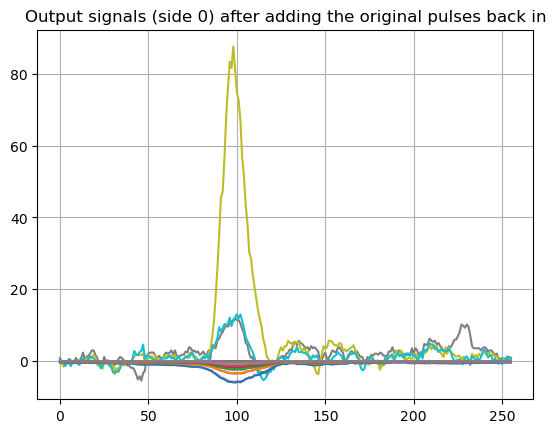

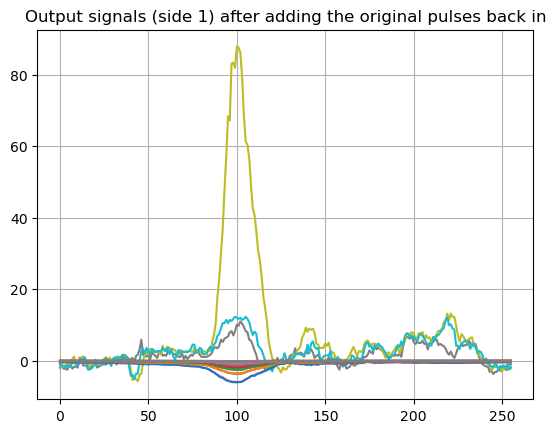

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [52]:
# Initialize IFFT-relevant matrices
output_signals_side0 = np.zeros((num_time_steps, P/2), dtype=complex)
output_signals_side1 = np.zeros((num_time_steps, P/2), dtype=complex)

time_signal_side0 = np.zeros((num_time_steps, P/2), dtype=complex)
time_signal_side1 = np.zeros((num_time_steps, P/2), dtype=complex)

phase_adjustment_side0 = np.zeros((num_time_steps, P/2), dtype=complex)
phase_adjustment_side1 = np.zeros((num_time_steps, P/2), dtype=complex)

# Perform the IFFT and truncate the result
for port in range(P/2):
    # Perform the IFFT with padding, but truncate to match num_time_steps
    time_signal_side0[:, port] = np.abs(np.fft.ifft(output_frequency_domain_side0[:, port], n=num_pad)[:num_time_steps])
    time_signal_side1[:, port] = np.abs(np.fft.ifft(output_frequency_domain_side1[:, port], n=num_pad)[:num_time_steps])

    # Adjust the phase to match the original signal's angle (truncating to num_time_steps)
    phase_adjustment_side0[:, port] = np.exp(1j * np.angle(time_signal_side0[:, port], deg=False)[:num_time_steps])
    phase_adjustment_side1[:, port] = np.exp(1j * np.angle(time_signal_side1[:, port], deg=False)[:num_time_steps])

    # Apply phase adjustment to the IFFT result
    output_signals_side0[:, port] = -time_signal_side0[:, port] * phase_adjustment_side0[:, port]
    output_signals_side1[:, port] = -time_signal_side1[:, port] * phase_adjustment_side1[:, port]

# Replace excited strips with original input pulses for visualization (assuming crosstalk effects on these strips are small or negligible)
output_signals_side0[:, secondary1_row] = secondary_strip1_side0
output_signals_side1[:, secondary1_row] = secondary_strip1_side1
output_signals_side0[:, primary_row] = primary_strip_side0
output_signals_side1[:, primary_row] = primary_strip_side1
output_signals_side0[:, secondary2_row] = secondary_strip2_side0
output_signals_side1[:, secondary2_row] = secondary_strip2_side1

# Plot output signals
for port in range(P/2):
    plt.plot(output_signals_side0[:, port], label='Port ' + str(port+1))
plt.grid()
plt.title('Output signals (side 0) after adding the original pulses back in')
plt.show()

for port in range(P/2):
    plt.plot(output_signals_side1[:, port], label='Port ' + str(port+1))
plt.grid()
plt.title('Output signals (side 1) after adding the original pulses back in')
plt.show()

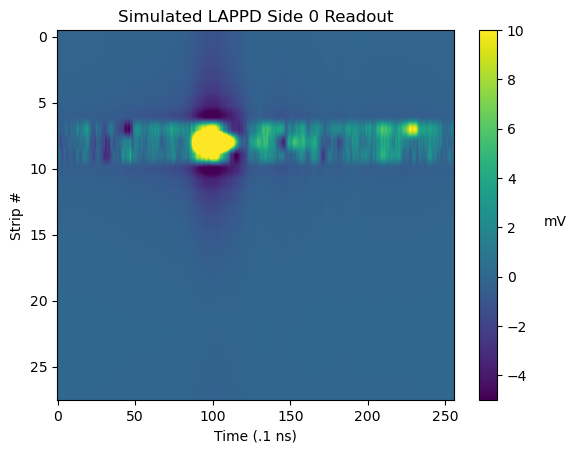

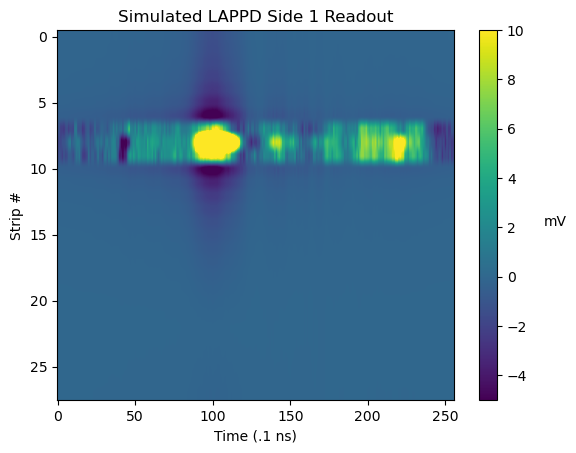

In [64]:
# Plot simulated color-temperature plots

# Use the real part to keep negative values
real_part_side0 = np.real(output_signals_side0[:, :28])

# Rotate the image by 90 degrees counterclockwise
rotated_image_side0 = np.rot90(real_part_side0)
# Flip the rotated image vertically
flipped_image_side0 = np.flipud(rotated_image_side0)

# Display the color plot with a stretched aspect ratio
plt.imshow(flipped_image_side0, cmap='viridis', aspect='auto', vmin=-5, vmax=10)  # 'auto' stretches the image to fit the axes
cbar = plt.colorbar()
cbar.set_label('mV', rotation='horizontal', labelpad=20)
plt.title('Simulated LAPPD Side 0 Readout')
plt.xlabel('Time (.1 ns)')
plt.ylabel('Strip #')
plt.show()

# Use the real part to keep negative values
real_part_side1 = np.real(output_signals_side1[:, :28])

# Rotate the image by 90 degrees counterclockwise
rotated_image_side1 = np.rot90(real_part_side1)
# Flip the rotated image vertically
flipped_image_side1 = np.flipud(rotated_image_side1)

# Display the color plot with a stretched aspect ratio
plt.imshow(flipped_image_side1, cmap='viridis', aspect='auto', vmin=-5, vmax=10)  # 'auto' stretches the image to fit the axes
cbar = plt.colorbar()
cbar.set_label('mV', rotation='horizontal', labelpad=20)
plt.title('Simulated LAPPD Side 1 Readout')
plt.xlabel('Time (.1 ns)')
plt.ylabel('Strip #')
plt.show()
